## Is it a bird?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-tran

In [6]:
os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

'Interactive'

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

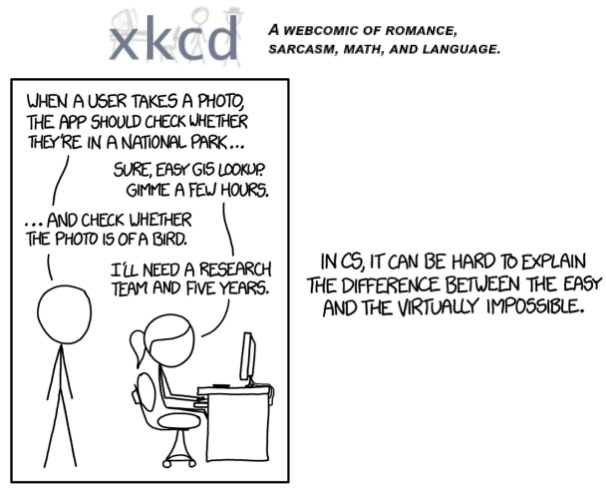

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [8]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [9]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://www.highreshdwallpapers.com/wp-content/uploads/2014/05/Colourful-Flying-Bird.jpg'

...and then download a URL and take a look at it:

In [12]:
os.getcwd()

'/kaggle/working'

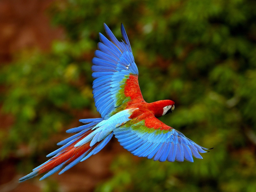

In [13]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


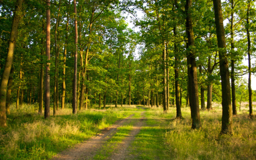

In [14]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [24]:
searches = 'mashroom','forest'
path = Path('mashroom_or_forest')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(2)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(2)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(2)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'mashroom photo'
Searching for 'mashroom sun photo'
Searching for 'mashroom shade photo'
Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'


In [28]:
path.unlink

<bound method Path.unlink of Path('mashroom_or_forest')>

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [29]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

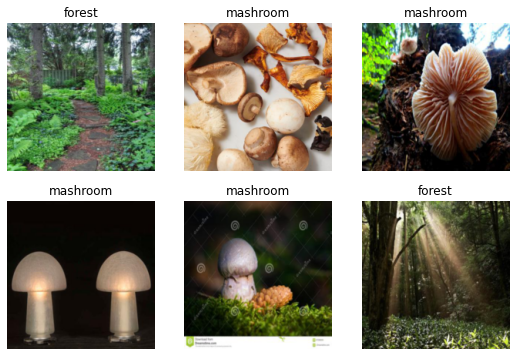

In [30]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [31]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.232092,0.052008,0.000000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.160829,0.018314,0.000000,00:01
1,0.089203,0.021541,0.000000,00:01
2,0.084727,0.020941,0.000000,00:01
3,0.061365,0.015310,0.000000,00:01
4,0.048658,0.012043,0.000000,00:01
5,0.041618,0.009969,0.000000,00:01
6,0.034360,0.008257,0.000000,00:01
7,0.029067,0.007449,0.000000,00:01
8,0.025418,0.006660,0.000000,00:01
9,0.022203,0.004475,0.000000,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [37]:
is_bird,_,probs = learn.predict(PILImage.create('mashroom_or_forest/mashroom/0371dd3c-d43a-40b5-a524-f9e4dea608df.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: mashroom.
Probability it's a bird: 0.0001


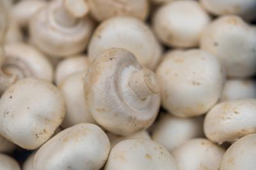

In [38]:
Image.open('mashroom_or_forest/mashroom/0371dd3c-d43a-40b5-a524-f9e4dea608df.jpg').to_thumb(256,256)

In [36]:
!ls  mashroom_or_forest/mashroom/0371dd3c-d43a-40b5-a524-f9e4dea608df.jpg

0371dd3c-d43a-40b5-a524-f9e4dea608df.jpg
1174201d-a36f-4dc1-a473-e3db70becd57.jpg
14ed9317-5fed-47b6-9e60-08c156ddde17.jpg
183acf19-4636-472a-97bf-f4547b30e598.jpg
1afcefab-8440-4aa7-a423-7f7eccb881a2.jpg
1e89bed7-9366-4986-a67a-7ee30376ab45.jpg
22f844c1-180e-4a12-bc20-79fbced20349.jpg
26f6da27-3228-48ee-be06-f1e52faea196.jpg
27509d56-1541-4f21-b708-a14ae81c5dd6.jpg
2ed5c49a-a6a3-4704-93cc-4534d39c6fc6.jpg
3108cedb-7cdb-4e5c-84dd-ee8e0c63d739.jpg
314726c5-b756-4bbd-bf5a-08e4e362726f.jpg
365d96b7-2948-4a89-aa6a-8db8a263e704.jpg
38072a2e-3b28-457f-a533-23f69196c691.jpg
391d5386-78b0-485f-aeea-cc75632469ef.jpg
3b06df6a-fcab-4638-89b3-929f1665662a.jpg
3c5545ea-9db9-43ae-997e-fb66d40595b2.jpg
3d669d66-1623-48b6-ab3d-c7b9e1ca1c3b.jpg
40aacb9c-b393-44f9-9526-201a3235b1d9.jpg
473237fd-79ed-410b-8333-ec15d9eeeb73.jpg
49c92746-e8ce-4e87-be96-d368b0d621e6.jpg
4b45cdb1-df52-4c1a-98fb-4729f5e27357.jpg
4c5cb479-3460-4a5c-a9f2-dcc3ba7a1228.jpg
4d4a5ba3-528a-4cc3-9442-598a795b5f51.jpg
4f1bc71c-1b33-46

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

In [ ]:
learn

In [3]:
!ls

__notebook_source__.ipynb


In [29]:
!git init

Reinitialized existing Git repository in /kaggle/working/.git/


In [5]:
echo "# fastai_learning" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/gmojko/fastai_learning.git
git push -u origin main

There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=<remote>/<branch> master



In [13]:
!git config --global user.email "corsier@gmail.com"
!git config --global user.name "gmojko"

In [22]:
!git commit -m "first commit"

On branch master

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	README.md
	__notebook_source__.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [24]:
!git commit -m "Init_commit"

On branch master

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	README.md
	__notebook_source__.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [26]:
!git branch -M main

error: refname refs/heads/master not found
fatal: Branch rename failed


In [28]:
!ls ..

input  lib  working


In [18]:
!git remote add origin https://github.com/gmojko/fastai_learning.git

In [20]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/gmojko/fastai_learning.git'


In [21]:
!echo "# fastai_learning" >> README.md

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.